# Проект для «Викишоп» (Обработка естественного текста на наличие токсичных высказываний)

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества F1 не меньше 0.75. 

## Описание данных

Столбец text в нём содержит текст комментария, а toxic — целевой признак.

## Оглавление
1. Подготовка данных
2. Обучение моделей
3. Анализ моделей
4. Тест лучшей модели

In [1]:
# Блок импорта
import pandas as pd
import re
import math
import numpy as np
import matplotlib.pyplot as plt

import spacy
import en_core_web_sm
from spacy.lookups import Lookups

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression

from sklearn.utils import shuffle

import transformers
from tqdm import notebook

from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# Подготовка данных

In [2]:
# Определим константы
RANDOM_STATE = 12345
TARGET_NAME = 'toxic'

In [3]:
try:
    df = pd.read_csv('toxic_comments.csv')
except FileNotFoundError: 
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
# Получим список стоп-слов
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Баланс классов

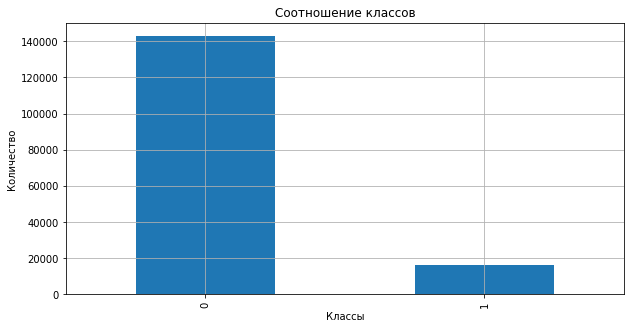

In [6]:
# Проверим дисбаланс классов
fig, ax = plt.subplots()
ax.set_title('Соотношение классов')
ax.set_xlabel('Классы')
ax.set_ylabel('Количество')
df[TARGET_NAME].value_counts().plot(kind='bar', figsize=(10, 5),grid = True);

### Промежуточный вывод

Выявлен сильный дисбаланс классов

## Анализ комментариев

In [7]:
# Посмотрим на параметры текста
min_size_all = df['text'].str.len().min()
min_size_all

5

In [8]:
max_size_all = df['text'].str.len().max()
max_size_all

5000

In [9]:
# Проверим, что у нас действительно только английский текст
russian_regexp = r'[а-яА-ЯёЁ]'
english_regexp = r'[A-Za-z]'

def check_russian(value):
    return int(re.search(russian_regexp, value) is not None)

df['is_russian'] = df['text'].apply(check_russian)
df['is_russian'].value_counts()

0    159033
1       259
Name: is_russian, dtype: int64

In [10]:
# Посмотрим, что за русские ребята
pd.set_option('display.max_colwidth', -1)
print(df[df['is_russian'] == 1]['text'].head(2))

126    Ahh, Hello Witzeman \n\n203.92.84.161  \nSymbols: ~ | ¡ ¿ † ‡ ↔ ↑ ↓ • ¶   # ½ ⅓ ⅔ ¼ ¾ ⅛ ⅜ ⅝ ⅞ ∞   ‘ “ ’ ” «»   ¤ ₳ ฿ ₵ ¢ ₡ ₢ $ ₫ ₯ € ₠ ₣ ƒ ₴ ₭ ₤ ℳ ₥ ₦ № ₧ ₰ £ ៛ ₨ ₪ ৳ ₮ ₩ ¥   ♠ ♣ ♥ ♦   m² m³ \nCharacters: Á á Ć ć É é Í í Ĺ ĺ Ń ń Ó ó Ŕ ŕ Ś ś Ú ú Ý ý Ź ź   À à È è Ì ì Ò ò Ù ù   Â â Ĉ ĉ Ê ê Ĝ ĝ Ĥ ĥ Î î Ĵ ĵ Ô ô Ŝ ŝ Û û Ŵ ŵ Ŷ ŷ   Ä ä Ë ë Ï ï Ö ö Ü ü Ÿ ÿ   ß   Ã ã Ẽ ẽ Ĩ ĩ Ñ ñ Õ õ Ũ ũ Ỹ ỹ   Ç ç Ģ ģ Ķ ķ Ļ ļ Ņ ņ Ŗ ŗ Ş ş Ţ ţ   Đ đ   Ů ů   Ǎ ǎ Č č Ď ď Ě ě Ǐ ǐ Ľ ľ Ň ň Ǒ ǒ Ř ř Š š Ť ť Ǔ ǔ Ž ž   Ā ā Ē ē Ī ī Ō ō Ū ū Ȳ ȳ Ǣ ǣ   ǖ ǘ ǚ ǜ Ă ă Ĕ ĕ Ğ ğ Ĭ ĭ Ŏ ŏ Ŭ ŭ   Ċ ċ Ė ė Ġ ġ İ ı Ż ż   Ą ą Ę ę Į į Ǫ ǫ Ų ų   Ḍ ḍ Ḥ ḥ Ḷ ḷ Ḹ ḹ Ṃ ṃ Ṇ ṇ Ṛ ṛ Ṝ ṝ Ṣ ṣ Ṭ ṭ   Ł ł   Ő ő Ű ű   Ŀ ŀ   Ħ ħ   Ð ð Þ þ   Œ œ   Æ æ Ø ø Å å   Ə ə    \nGreek: Ά ά Έ έ Ή ή Ί ί Ό ό Ύ ύ Ώ ώ   Α α Β β Γ γ Δ δ   Ε ε Ζ ζ Η η Θ θ   Ι ι Κ κ Λ λ Μ μ   Ν ν Ξ ξ Ο ο Π π   Ρ ρ Σ σ ς Τ τ Υ υ   Φ φ Χ χ Ψ ψ Ω ω    \nCyrillic: А а Б б В в Г г   Ґ ґ Ѓ ѓ Д д Ђ ђ   Е е Ё ё Є є Ж ж   З з Ѕ ѕ И и І і   Ї ї Й й Ј ј К к   Ќ ќ Л л Љ љ М м   Н н Њ њ О о П п   Р р

/tmp/ipykernel_78/3671578033.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [11]:
# Вернем, как было
pd.set_option('display.max_colwidth', 50)
del df['is_russian']

### Промежуточный вывод
Количество комментариев, содержащий русские слова крайне мало с подавляющим большинсвом английских комментариев, поэтому смело можно их удалить. + (Комментарии на русском фактически могут быть анлийскими, сожержа при этом всего одно русское слово)

Далее нам необходимо очистить текст от ссылок, имейлов, имен и прочих слов, не являющихся непосредственным комментарием пользователя. Задача кажется не сложной, однако английский язык в отличии от русского содержит множество форм сокращения с которыми нам прийдется считаться.

## Обработка текста

In [12]:
# Создадим столбец для обработанного текста, сразу приведем к нижнему регистру

df['text_prepared'] = df['text'].str.lower()

reduction_dict = dict()
reduction_dict["i'm"] = 'i am'
reduction_dict["i'd"] = 'i had'
reduction_dict["i'll"] = 'i will'
reduction_dict["i've"] = 'i have'
reduction_dict["you're"] = 'you are'
reduction_dict["you'd"] = 'you had'
reduction_dict["you'll"] = 'you will'
reduction_dict["you've"] = 'you have'
reduction_dict["he's"] = 'he is'
reduction_dict["he'd"] = 'he had'
reduction_dict["he'll"] = 'he will'
reduction_dict["she's"] = 'she is'
reduction_dict["she'd"] = 'she had'
reduction_dict["she'll"] = 'she will'
reduction_dict["it's"] = 'it is'
reduction_dict["it'll"] = 'it will'
reduction_dict["we're"] = 'we are'
reduction_dict["we'd"] = 'we would'
reduction_dict["we'll"] = 'we will'
reduction_dict["we've"] = 'we have'
reduction_dict["they're"] = 'they are'
reduction_dict["they'd"] = 'they had'
reduction_dict["they'll"] = 'they will'
reduction_dict["they've"] = 'they have'
reduction_dict["there's"] = 'there is'
reduction_dict["there'll"] = 'there will'
reduction_dict["there'd"] = 'there would'
reduction_dict["isn't"] = 'is not'
reduction_dict["aren't"] = 'are not'
reduction_dict["don't"] = 'do not'
reduction_dict["doesn't"] = 'does not'
reduction_dict["wasn't"] = 'was not'
reduction_dict["weren't"] = 'were not'
reduction_dict["didn't"] = 'did not'
reduction_dict["haven't"] = 'have not'
reduction_dict["hasn't"] = 'has not'
reduction_dict["won't"] = 'will not'
reduction_dict["hadn't"] = 'had not'
reduction_dict["can't"] = 'cannot'
reduction_dict["couldn't"] = 'could not'
reduction_dict["mustn't"] = 'must not'
reduction_dict["mightn't"] = 'might not'
reduction_dict["needn't"] = 'need not'
reduction_dict["shouldn't"] = 'should not'
reduction_dict["oughtn't"] = 'ought not'
reduction_dict["wouldn't"] = 'would not'
reduction_dict["what's"] = 'what is'
reduction_dict["how's"] = 'how is'
reduction_dict["where's"] = 'where is'

In [13]:
def uncover_reduction(string):
    # Чтобы ускориться, заменим все символы ’ на '
    string_tmp = string.replace('’', "'")

    # Чтобы не перебирать все ключи для каждой строки, для начала отсеим строки, которые вообще не содержат символы сокращений
    if (string_tmp.find("'") == -1):
        return string_tmp

    # Даже если нашли, это могли быть просто слова в кавычках, проверим, что они попадают под сокращения
    parts = ("'s ", "'t ", "'ll ", "'ve ", "'m ", "'d ", "'re ")
    founded = False
    for part in parts:
        if (string_tmp.find(part) != -1):
            founded = True
            break;

    # если не нашли сокращения, возвращаем строку как есть (после замены)
    if not founded:
        return string_tmp

    # если нашли сокращения, используем наш словарь и производим замены
    for key, value in reduction_dict.items():
        string_tmp = string_tmp.replace(key, value)
    
    return string_tmp

In [14]:
df['text_prepared'] = df['text_prepared'].apply(uncover_reduction)

df[['text', 'text_prepared']].head()

,text,text_prepared
0,Explanation\nWhy the edits made under my usern...,explanation\nwhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...,d'aww! he matches this background colour i am ...
2,"Hey man, I'm really not trying to edit war. It...","hey man, i am really not trying to edit war. i..."
3,"""\nMore\nI can't make any real suggestions on ...","""\nmore\ni cannot make any real suggestions on..."
4,"You, sir, are my hero. Any chance you remember...","you, sir, are my hero. any chance you remember..."


In [15]:
# Очистим текст. Только сделаем это в отдельном поле, т.к. подготовленный текст может понадобится для других моделей

def clean_text(string):
    string = re.sub(r"[\n\r]", " ", string)
    string = re.sub(r"[^a-zA-Z ]+", "", string)
    return string.strip()

In [16]:
df['text_cleared'] = df['text_prepared'].apply(clean_text)

df[['text', 'text_cleared']].head()

,text,text_cleared
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww he matches this background colour i am se...
2,"Hey man, I'm really not trying to edit war. It...",hey man i am really not trying to edit war it ...
3,"""\nMore\nI can't make any real suggestions on ...",more i cannot make any real suggestions on imp...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


In [17]:
%%time

# Проведем лемматизацию

lookups = Lookups()
lookups.add_table("lemma_rules", {"noun": [["s", ""]]})
nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.get_pipe("lemmatizer")
nlp = en_core_web_sm.load()

def lemmatize(string):
    result = []
    for token in nlp(string):
        # тут же очистим стоп-слова
        if token.is_stop == False:
            result.append(token.lemma_)
    return ' '.join(result)

CPU times: user 1.12 s, sys: 129 ms, total: 1.25 s
Wall time: 1.75 s


In [18]:
%%time
df['text_lemmas'] = df['text_cleared'].apply(lemmatize)

df[['text', 'text_lemmas']].head()

CPU times: user 41min 16s, sys: 3.51 s, total: 41min 20s
Wall time: 41min 32s


,text,text_lemmas
0,Explanation\nWhy the edits made under my usern...,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,daww match background colour seemingly stuck t...
2,"Hey man, I'm really not trying to edit war. It...",hey man try edit war guy constantly remove rel...
3,"""\nMore\nI can't make any real suggestions on ...",real suggestion improvement wonder section s...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page s


In [19]:
# Подчеркнул идею в другой работе - добавим метапризнаки по нашему тексту

# Количество символов
df['char_count'] = df['text'].str.len()

# Количество слов и уникальных слов
df['words_count'] = df['text_cleared'].str.count(' ') + 1

# знаю, что можно решить проще, но пытался по разному - либо юпитер падает, либо выдает не то, что надо
def unique_words_counter(string):
    string = str(string)
    return len(set(string.split()))

df['words_unique_count'] = df['text_cleared'].apply(unique_words_counter)

# Наличие стоп-слов
def bad_words_counter(string):
    string = str(string)
    words = string.split()
    result_counter = 0
    for word in words:
        if word in STOP_WORDS:
            result_counter += 1
    
    return result_counter
            

df['bad_words_count'] = df['text'].apply(bad_words_counter)

# Средняя длина слова
def word_len_mean_counter(string):
    string = str(string)
    words = string.split()
    return sum(len(word) for word in words) / len(words)

df['words_len_mean'] = df['text'].apply(word_len_mean_counter)

df[['text', 'char_count', 'words_count', 'words_unique_count', 'bad_words_count', 'words_len_mean']].head()

,text,char_count,words_count,words_unique_count,bad_words_count,words_len_mean
0,Explanation\nWhy the edits made under my usern...,264,46,41,14,5.162791
1,D'aww! He matches this background colour I'm s...,112,19,15,1,5.588235
2,"Hey man, I'm really not trying to edit war. It...",233,44,40,18,4.571429
3,"""\nMore\nI can't make any real suggestions on ...",622,114,77,49,4.486726
4,"You, sir, are my hero. Any chance you remember...",67,13,12,4,4.230769


### Промежуточный вывод
Мы обработали тексты комментариев:
- Привели все комментарии к нижнему регистру
- Разобрались с проблемой сокращений в анлийском языке
- Учли возможные ошибки при разделении слов с кавычками, запятыми, опострофами
- Провели лиммитизацию и соединили слова в соответствующие фразы
- Посчитали и добавили в датасет важные и нужные для предсказаний признаки:
    - Количество слов в комментарии
    - Количество букв в комментарии
    - Количество `плохих` букв
    - Среднюю длину слова

# Анализ текста

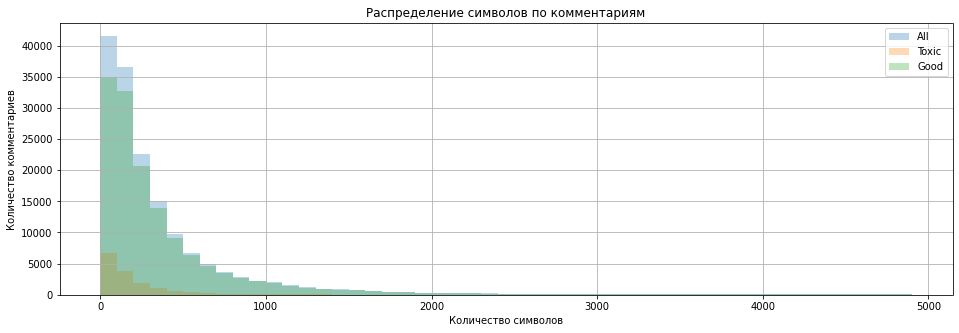

In [20]:
# Выведем графики

fig, ax = plt.subplots(1)
ax.set_title('Распределение символов по комментариям')
ax.set_xlabel('Количество символов')
ax.set_ylabel('Количество комментариев')

df['char_count'].hist(bins=range(0, 5000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='All')
df[df['toxic'] == 1]['char_count'].hist(bins=range(0, 5000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='Toxic')
df[df['toxic'] == 0]['char_count'].hist(bins=range(0, 5000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='Good')
ax.legend()

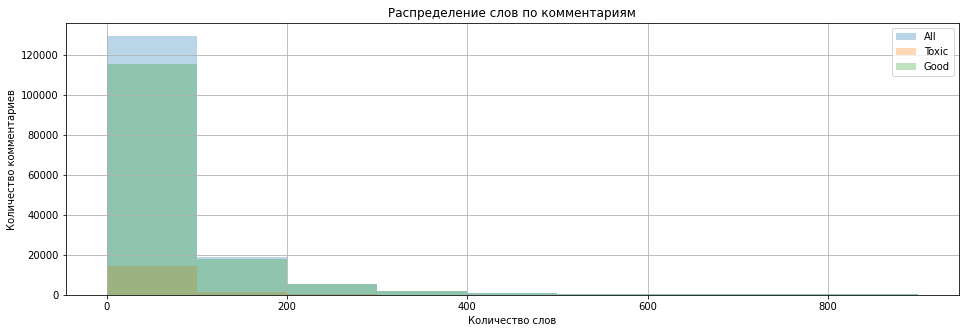

In [21]:
fig, ax = plt.subplots(1)
ax.set_title('Распределение слов по комментариям')
ax.set_xlabel('Количество слов')
ax.set_ylabel('Количество комментариев')

df['words_count'].hist(bins=range(0, 1000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='All')
df[df['toxic'] == 1]['words_count'].hist(bins=range(0, 1000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='Toxic')
df[df['toxic'] == 0]['words_count'].hist(bins=range(0, 1000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='Good')
ax.legend()

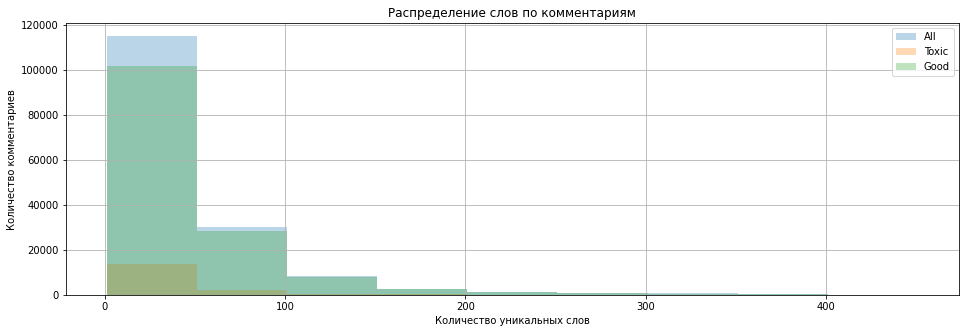

In [22]:
fig, ax = plt.subplots(1)
ax.set_title('Распределение слов по комментариям')
ax.set_xlabel('Количество уникальных слов')
ax.set_ylabel('Количество комментариев')

df['words_unique_count'].hist(bins=range(1, 500, 50), figsize=(16,5), alpha=0.3, ax=ax, label='All')
df[df['toxic'] == 1]['words_unique_count'].hist(bins=range(1, 500, 50), figsize=(16,5), alpha=0.3, ax=ax, label='Toxic')
df[df['toxic'] == 0]['words_unique_count'].hist(bins=range(1, 500, 50), figsize=(16,5), alpha=0.3, ax=ax, label='Good')
ax.legend()

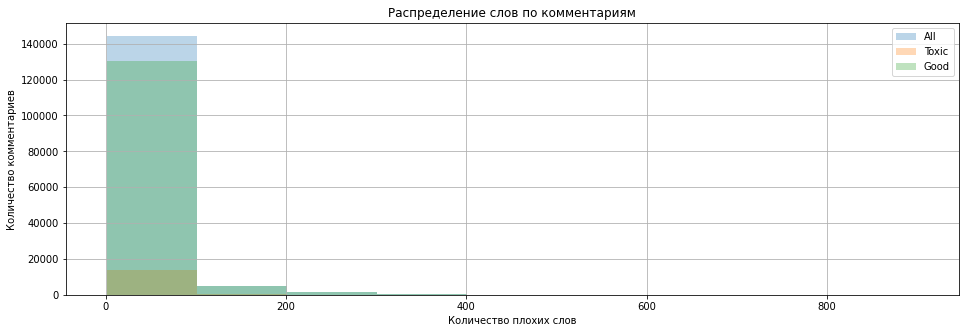

In [23]:
fig, ax = plt.subplots(1)
ax.set_title('Распределение слов по комментариям')
ax.set_xlabel('Количество плохих слов')
ax.set_ylabel('Количество комментариев')

df['bad_words_count'].hist(bins=range(1, 1000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='All')
df[df['toxic'] == 1]['bad_words_count'].hist(bins=range(1, 1000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='Toxic')
df[df['toxic'] == 0]['bad_words_count'].hist(bins=range(1, 1000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='Good')
ax.legend()

## Промежуточный вывод
Особых, разитильных отличий плохих текстов от хороших мы не нашли. Однако можно предположить изходя из построенных графиков, что плохие тексты обычно содержат меньше слов в целом, а также меньше уникальных слов в частности.

Построенные гистаграммы в очередной раз показывают нам очевидный сильный дисбаланс классов, который нам предстоит исправить перед обучением моделей.

# Обучение моделей

In [41]:
train, test = train_test_split(df,test_size=0.1, shuffle=True, random_state=RANDOM_STATE)

In [42]:
df_toxic = train[train['toxic'] == 1]
df_not_toxic = train[train['toxic'] == 0]

In [43]:
#df_downsampled = pd.concat([df_toxic] + [df_not_toxic.sample(n=len(df_toxic), random_state=RANDOM_STATE)])
#df_downsampled['toxic'].value_counts()

In [44]:
features_train = train['text_lemmas']
target_train = train['toxic']

In [45]:
features_test = test['text_lemmas']
target_test = test['toxic']

In [46]:
# Посмотрим на Tf-idf и логистическую регрессию

count_tf_idf = TfidfVectorizer(stop_words=STOP_WORDS) 
count_tf_idf.fit(features_train) 
tf_idf = count_tf_idf.transform(features_train)

In [47]:
# Определим scorer

f1 = make_scorer(f1_score, average='binary')

In [48]:
%%time
# Посмотрим на параметры

parameters = {'C': (0.5, 0, 10), 'fit_intercept': (True, False), 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
grid = GridSearchCV(model, parameters, cv=3, scoring=f1)
grid.fit(tf_idf, target_train)

grid.best_params_

# Для отладки - 'C': 1.0, 'fit_intercept': False, 'solver': 'sag'

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_sco

CPU times: user 9min 24s, sys: 9min 23s, total: 18min 48s
Wall time: 19min 37s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


{'C': 10, 'fit_intercept': True, 'solver': 'saga'}

In [49]:
grid.best_score_

0.7665231845099623

In [33]:
#%%time
## Попробуем SVC
#
#parameters = {'C': (0.5, 0, 10), 'kernel': ('linear', 'poly', 'rbf')}
#model = SVC(random_state=RANDOM_STATE, class_weight='balanced')
#grid = GridSearchCV(model, parameters, cv=3, scoring=f1)
#grid.fit(tf_idf, target_train)
#
#grid.best_params_
#
## Для отладки - {'C': 1.0, 'kernel': 'linear'}

In [34]:
#grid.best_score_

<a href="https://ibb.co/JtSfp1c"><img src="https://i.ibb.co/GprKM6d/12-01-23-20-25-55.png" alt="12-01-23-20-25-55" border="0"></a><br /><a target='_blank' href='https://ru.imgbb.com/'>фото в гиф</a><br />

## Промежуточный вывод
Лучше всего по итогу обучения себя оказала модель SVC, поэтому тестовую выборку прогоним через неё.

# Тест лучшей модели

In [50]:
%%time

model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', C = 10, fit_intercept = True, solver = 'newton-cg')
model.fit(tf_idf, target_train)

CPU times: user 16.6 s, sys: 24 s, total: 40.6 s
Wall time: 40.9 s


LogisticRegression(C=10, class_weight='balanced', random_state=12345,
                   solver='newton-cg')

In [52]:
tf_idf_test = count_tf_idf.transform(features_test)

In [53]:
predicted = model.predict(tf_idf_test)

f1_score(target_test, predicted)

0.772020725388601

In [40]:
# Проверим модель на адекватность
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(tf_idf, target_train)
predicted = dummy_clf.predict(tf_idf_test)
f1_score(target_test, predicted)

0.18378748147303617

# Общий вывод

Время подводить итоги проделанной работы:\
В рамках подготовки данных мы:
- Выявили сильный дисбаланс классов текстов
- Провели анализ текстов, удалив комментарии на русском языке
Мы обработали тексты комментариев:
- Привели все комментарии к нижнему регистру
- Разобрались с проблемой сокращений в анлийском языке
- Учли возможные ошибки при разделении слов с кавычками, запятыми, опострофами
- Провели лиммитизацию и соединили слова в соответствующие фразы
- Посчитали и добавили в датасет важные и нужные для предсказаний признаки:
    - Количество слов в комментарии
    - Количество букв в комментарии
    - Количество `плохих` букв
    - Среднюю длину слова

Проанализировав тексты комментариев мы пришли к выводу о незначительных отличиях в содержании текстов каждого из классов комментариев.

Были обучены и проверены на валидационной выборке две модели машинного обучения: `LogisticRegression` и `SVC`. По итогу лучшие результаты F1-метрики показала модель `SVC`, которая была использована в дальнейшем для предсказания значений на тестовой выборке.

Гиперпараметры использованные в модели `LogisticRegression` 'C': 10, 'fit_intercept': True, 'solver': 'newton-cg'

Модель на тестовой выборке показала значение F1-метрики в 0.77, что отвечает требованию заказчика. Также проверенная на тестовой выборке модель отвечает кретериям адекватности. Это было проверено на константной модели.